# Лабораторная работа "Введение в ML"

В этой лабораторной мы:

- познакомимся с базовыми библиотеками для работы с табличными данными — `numpy` и `pandas`
- поближе посмотрим на простейшие задачи машинного обучения: классификацию и регрессию
- попробуем несколько метрик и поймем, почему выбор метрики это важно
- обучим несколько простых моделей
- увидим связь между сложностью модели и переобучением
- убедимся, что без данных все тлен

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, balanced_accuracy_score

from scipy.sparse import coo_matrix, hstack
from catboost import CatBoostClassifier

**1.** Реализуем функцию, принимающую на вход два одномерных массива `first_array` и `second_array` и возвращающую матрицу, в которой первый массив соответствует первому столбцу матрицы, второй — второму.

Операция транспонирования делает массив non-contiguous, поэтому воспользуемся, например, методом `reshape`

In [2]:
def construct_matrix(first_array: np.ndarray, second_array: np.ndarray) -> np.ndarray:
    """
    Construct matrix from pair of arrays
    :param first_array: first array
    :param second_array: second array
    :return: constructed matrix
    """
    assert (size := first_array.size) == second_array.size
    return np.hstack((first_array.reshape(size, 1), second_array.reshape(size, 1)))

In [37]:
construct_matrix(np.array([1, 2, 3]), np.array([4, 5, 6]))

array([[1, 4],
       [2, 5],
       [3, 6]])

**2.** Реализуем функцию, принимающую на вход массив целых неотрицательных чисел `nums` и возвращающую самый частый элемент массива

In [3]:
def most_frequent(nums: np.ndarray[np.int64]) -> np.int64:
    """
    Find the most frequent value in an array
    :param nums: array of ints
    :return: the most frequent value
    """
    values, counts = np.unique(nums, return_counts=True)
    return values[np.argmax(counts)]

In [12]:
most_frequent(np.array([1, 2, 2, 3, 3, 3]))

np.int64(3)

# Изучение данных

Прежде всего, загрузим данные и сделаем из них красивые pandas-таблички. Они взяты из параллели RecSys соревнования https://yandex.ru/cup/ml/. Но мы будем иметь дело не со всеми данными, а только с их частью. Данные у нас будут про заведения общественного питания. Файлы с данными можно найти [здесь](https://disk.yandex.ru/d/YWvCNRQMb7QSQA). Задачей будет **предсказание среднего чека** (average_bill) по некоторым другим свойствам заведения.

Посмотрим на данные. В этом нам поможет метод ``head`` pandas-таблички

In [6]:
data = pd.read_csv("organisations.csv")
features = pd.read_csv("features.csv")
rubrics = pd.read_csv("rubrics.csv")

data.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...


Полезно посмотреть внимательнее на то, с какими признаками нам предстоит работать.

* **org_id** нам не понадобится;
* **city** - город, в котором находится заведение (``msk`` или ``spb``);
* **average_bill** - средний чек в заведении - он будет нашим таргетом;
* **rating** - рейтинг заведения;
* **rubrics_id** - тип заведения (или несколько типов). Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``rubrics``
* **features_id** - набор неких фичей заведения. Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``features``

Чтобы быстро восстанавливать по рубрикам и фичам их нормальные названия, сделаем словари вида ``код_фичи:название_фичи``. Посмотрим, какими бывают типы заведений

In [5]:
feature_dict = features.set_index("feature_id")["feature_name"].to_dict()
rubric_dict = rubrics.set_index("rubric_id")["rubric_name"].to_dict()
print(rubric_dict)

{30519: 'Булочная, пекарня', 30770: 'Бар, паб', 30771: 'Быстрое питание', 30774: 'Кафе', 30775: 'Пиццерия', 30776: 'Ресторан', 30777: 'Столовая', 31286: 'Спортбар', 31350: 'Кондитерская', 31375: 'Суши-бар', 31401: 'Кальян-бар', 31495: 'Кофейня', 3108292683: 'Бар безалкогольных напитков', 3501514558: 'Фудкорт', 3501750896: 'Кофе с собой'}


Теперь время посмотреть на таргет. Вооружившись функциями `hist` и `scatter` из библиотеки `matplotlib`, а также методоми `isna` и `info` для pandas-таблиц разберемся, какие значения принимают таргеты, есть ли там там выбросы, пропуски или ещё какие-то проблемы

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68339 entries, 0 to 68338
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   org_id        68339 non-null  uint64 
 1   city          68339 non-null  object 
 2   average_bill  32778 non-null  float64
 3   rating        54608 non-null  float64
 4   rubrics_id    68339 non-null  object 
 5   features_id   57290 non-null  object 
dtypes: float64(2), object(3), uint64(1)
memory usage: 3.1+ MB


In [59]:
data["average_bill"].isna().sum()

np.int64(35561)

С пропусками можно бороться по-разному (даже и с пропусками в таргете), но пока мы сделаем самую простую вещь: дропнем все заведения, для которых мы не знаем средний чек. Помимо этого, посмотрим на выбросы

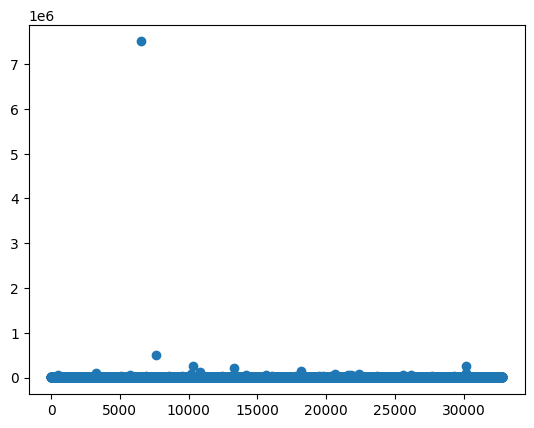

In [7]:
data.dropna(subset="average_bill", inplace=True, ignore_index=True)

plt.scatter(data["average_bill"].index, data["average_bill"])

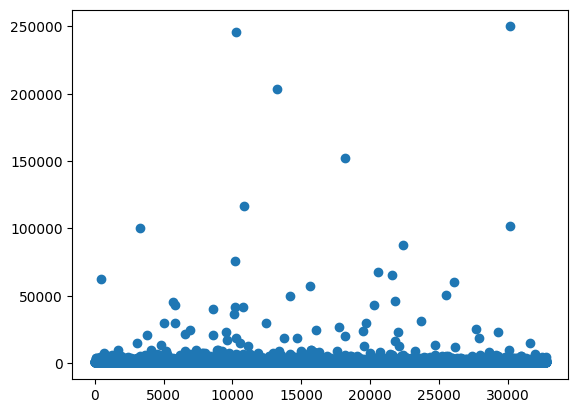

In [5]:
data = data[data["average_bill"] < 500000]
plt.scatter(data["average_bill"].index, data["average_bill"])

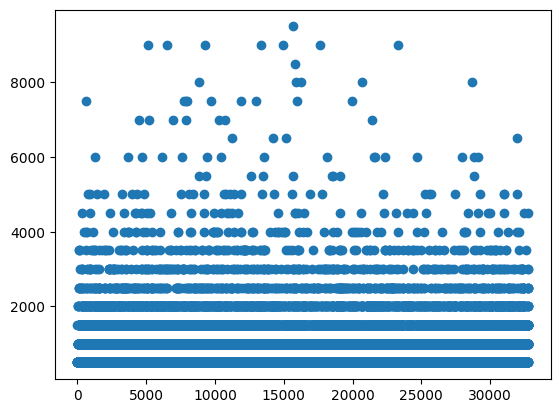

In [6]:
data = data[data["average_bill"] < 10000]
plt.scatter(data["average_bill"].index, data["average_bill"])

* Среди таргетов довольно много пропусков;
* Все таргеты - это числа, кратные 500;
* Есть какие-то адские значения, превышающие 100 000 (видимо, выбросы);
* В целом, число ресторанов с данным средним чеком быстро падает с ростом среднего чека. Для средних чеков, 
больших 2500, заведений уже совсем мало. Примерно у 2/3 заведений средний чек 500.

Уберем из них все заведения, у которых средний чек неизвестен или превышает 2500.

**3.** Введием количество оставшихся после очистки заведений.

Дальше мы будем работать с очищенными данными

In [8]:
data = data[data["average_bill"] <= 2500]
data.reset_index(drop=True, inplace=True)
len(data)

32136

**4.** Посчитаем разность между средними арифметическими average_bill в кафе Москвы и Санкт-Петербурга

In [7]:
# rubric_dict[30774] = "Кафе" 
data[data["rubrics_id"].apply(lambda s: s.find("30774") != -1)].groupby("city")["average_bill"].mean()

city
msk    781.080794
spb    638.677107
Name: average_bill, dtype: float64

Давайте ещё немного поизучаем данные и ответим на вопросы:

* Есть ли разница между средними чеками в Москве и Санкт-Петербурге?
* Коррелирует ли средний чек с рейтингом?
* Есть ли разница в среднем чеке между ресторанами и пабами?

In [33]:
data.groupby("city")["average_bill"].mean()

city
msk    792.887230
spb    676.449662
Name: average_bill, dtype: float64

In [34]:
data["average_bill"].corr(data["rating"])

np.float64(0.09026290021639105)

In [35]:
# rubric_dict[30776] = "Ресторан", rubric_dict[30770] = "Бар, паб"
print(
    data[data["rubrics_id"].apply(lambda s: s.find("30776") != -1)]["average_bill"].mean(),
    data[data["rubrics_id"].apply(lambda s: s.find("30770") != -1)]["average_bill"].mean()
)

995.471580262336 814.2432556012803


## Формулируем задачу

Прежде, чем решать задачу, её надо сформулировать.

**Вопрос первый**: это классификация или регрессия?

Ответ не столь однозначен, как хотелось бы. С одной стороны, таргет принимает всего четыре значения, и потому это может быть классификацией с 4 классами. С другой стороны, таргеты - это не абстрактные "треугольник", "круг", "квадрат", а вещественные числа, и когда мы вместо 500 предсказываем 2500, это явно хуже, чем вместо 1500 предсказать 2000. В целом, задачу можно решать и так, и так; мы будем смотреть на метрики обеих задач.

**Вопрос второй**: какие метрики мы будем использовать для оценки качества решения? Какие метрики вы предложили бы для этой задачи как для задачи классификации? А для этой задачи, как для задачи регрессии?

Начнём с классификации. Метрика accuracy не очень хороша из-за несбалансированности классов. Действительно, классификатор, который всегда говорит 500, будет иметь accuracy примерно 0.66, хотя это никак не отражает практическую ценность модели. Как мы увидим, самая большая проблема будет заключаться в том, чтобы научиться выделять заведения с большими чеками, а их меньше всего и в accuracy они вносят самый маленький вклад. Есть разные способы с этим бороться, один -- использовать sklearn.metrics.balanced_accuracy_score. Его идея, грубо говоря, в том, чтобы по каждому классу найти, какая доля объектов этого класса правильно классифицирована, а потом эти доли усреднить. Тогда у бессмысленного классификатора, который всем ставит 500, будет скор 1/5 (ведь классов 5), а чтобы получить прежние 2/3, нужно будет научиться в каждом классе правильно ставить хотя бы 2/3 меток.    
    
Теперь что касается регрессии. Основых метрики две - MSE и MAE. Из первой стоит извлекать корень, чтобы получать интерпретируемые человеком значения, а вторая менее агрессивна к выбросам (впрочем, выбросов тут уже нет, мы их все выкинули). Без дополнительной информации не очень понятно, какую выбирать, можно брать любую. А выбирать надо: ведь даже банальные модели "предсказывай всегда среднее" и "предсказывай всегда медиану" будут по-разному ранжироваться этими метриками.

**Вопрос третий**: а не взять ли нам какую-нибудь более экзотическую метрику? Например, MAPE (определение в учебнике в главе про оценку качества моделей). А как вам такое соображение: допустим, заказчик говорит, что пользователи будут расстраиваться, только если мы завысили средний чек - так давайте поправим MSE или MAE, обнуляя те слагаемые, для которых предсказанный таргет меньше истинного. Вот это хорошая метрика или нет?

Что касается MAPE, у нас нет тех проблем, с которой она борется. Вот если бы у нас были средние чеки от 500 до миллиона, мы бы столкнулись с ситуацией, что большие ошибки для больших чеков доминировали бы в сумме для MSE и MAE (500 вместо 1000 меркнет по сравнению с 500к вместо миллиона). Говоря поэтически, мы бы оптимизировали модель для миллионеров, забыв про простых трудяг. И было бы логично перейти от парадигмы "ошибаемся на 500 рублей" к парадигме "ошибаемся на 50%". Но у нас все таргеты примерно одного порядка, MAPE нам особо ни к чему.

Вторая метрика коварна тем, что её можно "накрутить" безо всякой пользы для дела. А именно, модель, которая всегда предсказывает средний чек в миллион, была бы идеальна. Но все бы расстраивались и не ходили есть. Другое дело, что можно ввести разные веса для ошибок в большую и в меньшую сторону, но опять же - пока нет показаний к тому, что это нужно.

## Применяем ML

Теперь время разбить данные на обучающую и тестовую выборку. Делается это с помощью функции `train_test_split` из пакета `sklearn`. При этом очень важно сделать стратификацию по таргету. В противном случае у нас в трейне и тесте могут оказаться разные пропорции классов (обычно особенно страдают мало представленные классы), что неутешительно скажется на результате

In [10]:
clean_data_train, clean_data_test = train_test_split(
    data, stratify=data['average_bill'], test_size=0.33, random_state=42)

Теперь нам нужен **бейзлайн** - очень простая модель, с которой мы в дальнейшем будем сравниваться.

Поскольку мы ещё не знаем никаких умных классов моделей, все модели мы будем писать руками. А именно, мы напишем две простых модели на основе ``sklearn.baseRegressorMixin`` и ``sklearn.base.ClassifierMixin``:

**5**. Модель для задачи регрессии, которая для всех заведений предсказывает одно число — среднее значение среднего чека.

**6**. Модель для задачи классификации, которая для всех заведений предсказывает один класс — самый частый класс (ироничным образом он в данном случае совпадает с медианой).

**Важно!** Информация из тестовой выборки не должна протекать в процесс обучения. Так вот, и среднее, и самый частый класс нужно считать именно на обучающей выборке!

Заметим, что для этих моделей нам вообще не нужны какие-то "фичи"; мы работаем только с таргетом.

У каждой модели есть (как минимум) два метода: `fit` (обучает модель по фичам `X` и таргету `y`) `predict` (предсказывает по фичам `X`)

In [16]:
from scipy.stats import mode
from sklearn.base import RegressorMixin, ClassifierMixin, BaseEstimator


class MeanRegressor(RegressorMixin, BaseEstimator):
    def __init__(self):
        self._mean = 0

    def fit(self, X, y):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        testing data features
        y : array like, shape = (_samples,)
        testing data targets
        '''
        self._mean = np.mean(y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return np.full(shape=X.shape[0], fill_value=self._mean)


class MostFrequentClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self):
        self._mode = 0

    def fit(self, X, y):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        self._mode = mode(y).mode
        self.is_fitted_ = True
        return self

    def predict(self, X):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return np.full(shape=X.shape[0], fill_value=self._mode)

Обучим наши модели и оценим их качество на тестовой выборке. В качестве метрик возьмём RMSE (``np.sqrt`` от ``sklearn.metrics.root_mean_squared_error``) и ``sklearn.metrics.balanced_accuracy_score``. Для регрессионной модели имеет смысл считать только RMSE (значения будут не кратны 500, точно мы угадывать не будем никогда), а вот для классификационной можно найти обе метрики

In [17]:
X_train = clean_data_train.loc[:, clean_data_train.columns != "average_bill"]
y_train = clean_data_train["average_bill"]

reg = MeanRegressor()
reg.fit(X_train, y_train)

clf = MostFrequentClassifier()
clf.fit(X_train, y_train)

MostFrequentClassifier()

In [18]:
X_test = clean_data_test.loc[:, clean_data_test.columns != "average_bill"]
y_test = clean_data_test["average_bill"]

print(
    root_mean_squared_error(y_test, reg.predict(X_test)),
    root_mean_squared_error(y_test, clf.predict(X_test)),
    balanced_accuracy_score(y_test, clf.predict(X_test))
)

448.7143889551622 514.7517402382093 0.2


Казалось бы, регрессор никогда не угадывает, но он в каком-то смысле лучше классификатора - справедливо ли это? Возможно. Несуществующий пользователь модели вряд ли будет задавать вопросы "почему средний чек не кратен 500?" Ну, выдали около 800 - ок, понятно

## Усложнение модели

Бейзлайны будут нашей отправной точкой. Строя дальнейшие модели, мы будем спрашивать себя: получилось ли лучше бейзлайна? Если прирост слабый, то в чём смысл усложнения? Начнём с использования фичи ``city``. Мы уже видели, что в разных городах и средние чеки разные. Легко проверить, что *медиана* средних чеков всё же одна и та же и в Москве, и в Санкт-Петербурге (ох уж этот вездесущий средний чек 500!), поэтому с классификатором мы ничего не сделаем. Но вот регрессор можно попробовать починить.

**7.** Напишем регрессор, для каждого заведения предсказывающий среднее значение в том же городе (на обучающей выборке, конечно)

In [19]:
from sklearn.base import RegressorMixin, BaseEstimator


class CityMeanRegressor(RegressorMixin, BaseEstimator):
    def __init__(self):
        self._mean = [0, 0]

    def fit(self, X, y):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        self._mean = (y[X["city"] == "msk"].mean(), y[X["city"] == "spb"].mean())
        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return (X["city"] == "msk") * self._mean[0] + (X["city"] == "spb") * self._mean[1]

Обучим регрессор и сравним его по метрике RMSE с бейзлайнами

In [20]:
creg = CityMeanRegressor()
creg.fit(X_train, y_train)
root_mean_squared_error(y_test, creg.predict(X_test))

np.float64(445.1063281403263)

Лучше стало, но, правда, не очень сильно. В этот момент очень важно не просто радовать руководителя приростом в третьем знаке, но и думать о том, что происходит.

Средний средний чек по Москве равен 793, в Санкт-Петербурге - 676, а в целом - 752 рубля. MSE, увы, не поможет вам ответить на вопрос, стало ли лучше пользователю, если вы ему вместо 752 рублей назвали 793. Здесь вскрывается весьма существенный порок MSE в этой задаче. Дело в том, что наш изначальный таргет делит заведения на некоторые "ценовые категории", и различие в средних чеках 500 и 1000 в самом деле существенно. Наверное, мы хотели бы как раз правильно предсказывать ценовые категории. Но MSE не очень помогает нам об этом судить. Дальше мы ещё подумаем, как это исправить.

В любом случае, несмотря на улучшение метрики, мы пока не можем судить, стало ли по жизни лучше от усложнения модели.

Немного подумав, возьмём на вооружение другую идею. Давайте использовать типы заведений!

Но с типами есть некоторая проблема: в столбце ``rubrics_id`` не всегда один идентификатор, часто их несколько, и всего комбинаций довольно много. Чтобы не возиться с малочисленными типами, давайте сольём их в один безликий ``other``.

Итак, добавим в обучающие и тестовые данные столбец ``modified_rubrics``, в котором будет то же, что и в ``rubrics_id``, если соответствующая комбинация рубрик содержит хотя бы 100 заведений из обучающей (!) выборки, и строка ``other`` в противном случае. Здесь поможет контейнер ``Counter`` из библиотеки ``collections``

In [21]:
from collections import Counter


def modify(rubrics, counter):
    try:
        if counter[rubrics] >= 100:
            return rubrics
    except KeyError:
        pass
    return "other"


counter = Counter(clean_data_train["rubrics_id"])
clean_data_train["modified_rubrics"] = clean_data_train["rubrics_id"].apply(lambda r: modify(r, counter))
clean_data_test["modified_rubrics"] = clean_data_test["rubrics_id"].apply(lambda r: modify(r, counter))

**8**. Теперь настало время написать могучий классификатор, который по заведению предсказывает медиану средних чеков среди тех в обучающей выборке, у которых с ним одинаковые `modified_rubrics` и город (вы спросите, почему медиану, а не самый частый -- спишем это на вдохновение; самый частый тоже можно брать - но медиана работает лучше)

In [22]:
from sklearn.base import ClassifierMixin, BaseEstimator

class RubricCityMedianClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self):
        self._median = None

    def fit(self, X, y):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        data = pd.concat((X, y), axis=1)
        self._median = data[X["city"] == "msk"].groupby("modified_rubrics")["average_bill"].median()
        self._median = self._median.apply(lambda x: [x, 0]).to_dict()
        for i, v in data[X["city"] == "spb"].groupby("modified_rubrics")["average_bill"].median().items():
            if i in self._median:
                self._median[i][1] = v
            else:
                self._median[i] = [0, v]
        self.is_fitted_ = True
        return self

    def predict(self, X):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return (X["city"] == "msk") * X["modified_rubrics"].apply(lambda r: self._median.get(r, [0, 0])[0]) + (X["city"] == "spb") * X["modified_rubrics"].apply(lambda r: self._median.get(r, [0, 0])[1])


In [23]:
X_train = clean_data_train.loc[:, clean_data_train.columns != "average_bill"]
y_train = clean_data_train["average_bill"]
X_test = clean_data_test.loc[:, clean_data_test.columns != "average_bill"]
y_test = clean_data_test["average_bill"]

In [24]:
mclf = RubricCityMedianClassifier()
mclf.fit(X_train, y_train)
print(
    root_mean_squared_error(y_test, mclf.predict(X_test)),
    balanced_accuracy_score(y_test, mclf.predict(X_test))
)

393.96675836287915 0.30552511833185647


В сравнии с бейзлайнами стало заметно лучше, хотя результаты все еще не впечатляют. Посмотрим, сколько объектов в каждом из классов удалось классифицировать правильно

In [25]:
pd.concat((y_test, y_test == mclf.predict(X_test)), axis=1).groupby("average_bill").aggregate(['count', 'sum'])

0      
             count   sum
average_bill            
500.0         7368  6608
1000.0        1809   700
1500.0         890   217
2000.0         391     0
2500.0         147     0

Приведённый выше "пайплайн" классификации был не очень удачным. Для новых данных нам бы пришлось пересчитывать все, ведь у нас могли появиться новые рубрики с хотя бы 100 представителями. А уж никакую кросс-валидацию с этим подходом и вовсе не сделать без боли

## Слишком простые и слишком сложные модели

Бейзлайны у нас слишком просты и потому не очень полезны в жизни. Но если сложность модели растёт бесконтрольно, то тоже получается плохо. Давайте рассмотрим конкретный пример и создадим классификатор, использующий одновременно `rubrics_id` и `features_id`:

- для каждого объекта создадим `modified_features` --- конкатенацию строки `rubrics_id`, разделителя 'q' и строки `features_id`. Причём на сей раз не будем выкидывать мало представленные значения (вся информация важна, не так ли?)
- Для тестовой выборки заменим все конкатенации, не встретившиеся в обучающей выборке, на строку `other`

То есть элементы в этом столбце будут иметь вид `other` или `30776 30774 q 3502045032 11741 3502045016 1046...`

In [12]:
clean_data_test

,org_id,city,average_bill,rating,rubrics_id,features_id
30106,14385912302763770021,spb,1000.0,4.748444,30776 30770 31401,11177 3501618484 10462 3501481355 1509 1416 20...
17310,16695436192794975203,msk,500.0,3.793758,30771,3501744275 273469383 3501513153 11617 10462 11...
9054,11841431940065207518,msk,500.0,3.606557,30771 30777,3501773763 3501744275 3501773764 3501618484 15...
9015,16028521499441205186,msk,2000.0,4.683841,30776,3501618484 20422 1082283206 11704 11629 21247 ...
9810,12477116204055673498,spb,500.0,4.165394,30776 31401 30770,1524 246 11704 1018 3501618484 2020795524 2124...
...,...,...,...,...,...,...
21883,9041226080397910513,msk,2500.0,4.408108,30776,11629 11704 10462 11617 3501744275 20424 35017...
28651,14998683880343589209,msk,1000.0,3.555556,30776,273469383 20424 20422 246 1416 11867 11629 104...
5127,1621254442333414922,msk,2000.0,4.402516,30776,273469383 21247 11867 1082283206 20422 246 101...
12028,5620614742257813954,msk,500.0,NaN,30771,11704 1018 273469383 10462 20422


In [10]:
X_train = clean_data_train.loc[:, clean_data_train.columns != "average_bill"]
X_train["modified_features"] = X_train[["rubrics_id", "features_id"]].apply(lambda r: r["rubrics_id"] + " q " + r["features_id"], axis=1)
y_train = clean_data_train["average_bill"]
X_test = clean_data_test.loc[:, clean_data_test.columns != "average_bill"]
X_test["modified_features"] = X_test[["rubrics_id", "features_id"]].apply(lambda r: r["rubrics_id"] + " q " + r["features_id"], axis=1)
y_test = clean_data_test["average_bill"]

In [ ]:
X_train

,org_id,city,rating,rubrics_id,features_id,modified_features
15268,3276960721840719260,msk,4.500000,30770,11704 20422 1018 11177 1416 11867 10462,30770 q 11704 20422 1018 11177 1416 11867 10462
11513,8452997364765928283,msk,4.442623,30774 30776,1415 3501481355 1416 11629 10462 1524 20422 11...,30774 30776 q 1415 3501481355 1416 11629 10462...
24869,14240408259222214074,spb,4.018868,30776 30774,3502045032 11741 3502045016 10462 11704 350177...,30776 30774 q 3502045032 11741 3502045016 1046...
18914,15114069072602161053,msk,4.364742,31401 30776,3501513153 3501779478 3491142672 273469383 350...,31401 30776 q 3501513153 3501779478 3491142672...
7617,2730337118800634815,msk,4.698718,30770,21247 10896 3491142672 11629 3501481353 350148...,30770 q 21247 10896 3491142672 11629 350148135...
...,...,...,...,...,...,...
29147,15641319025413596274,msk,4.510753,30771,20424 3501744275 273469383 10462 11177 11617 1...,30771 q 20424 3501744275 273469383 10462 11177...
16233,2049892259403324519,msk,4.333333,30771,273469383 20424 11704 11629 10462 20422 1018,30771 q 273469383 20424 11704 11629 10462 2042...
6236,12224074314753892871,msk,5.000000,30775,21247 11867 11629 1524 1509 20422 1416 1415 10...,30775 q 21247 11867 11629 1524 1509 20422 1416...
17089,16581456988770474074,msk,4.692308,31495 30774,3491142672 20282 3501637468 11741 3501745827 3...,31495 30774 q 3491142672 20282 3501637468 1174...


In [13]:
from sklearn.base import ClassifierMixin, BaseEstimator

class ModifiedFeaturesMedianClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self):
        self._median = None

    def fit(self, X, y):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        data = pd.concat((X, y), axis=1)
        self._median = data.groupby("modified_features")["average_bill"].median().to_dict()
        self._global_median = data["average_bill"].median()
        self.is_fitted_ = True
        return self

    def predict(self, X):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return X["modified_features"].apply(lambda r: self._median.get(r, self._global_median))


**9.** Теперь обучим классификатор, который для заведения предсказывает медиану среднего чека по всем объектам обучающей выборки с таким же, как у него, значением `modified_features`, а если такого в обучающей выборке нет, то глобальную медиану среднего чека по всей обучающей выборке

In [48]:
mclf = ModifiedFeaturesMedianClassifier()
mclf.fit(X_train, y_train)
y_pred = mclf.predict(X_test)
y_pred.astype(int).sort_values().to_csv("ans.csv", header=False)

**10.** Модель, очевидно, очень сложная. Число параметров (различных категорий) в ней сопоставимо с числом объектов в обучающей выборке. А получилось ли хорошо? Давайте посчитаем RMSE и balanced_accuracy_score на обучающей и на тестовой выборках

In [46]:
y_pred_train = mclf.predict(X_train)

In [47]:
print(
    root_mean_squared_error(y_train, y_pred_train),
    balanced_accuracy_score(y_train, y_pred_train),
    "\n",
    root_mean_squared_error(y_test, y_pred),
    balanced_accuracy_score(y_test, y_pred),
)

32.4162067388783 0.9931928777769354 
 513.9898108867789 0.2010249213051401


/home/yacan/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/yacan/.pyenv/versions/3.12.5/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Налицо переобучение: на трейне метрики отличные, на тесте - вообще никакие. В общем, не стоит гнаться за чрезмерной сложностью модели.

## ML без данных что компутер без электричества

Как видим, если данные не очень, то даже самая крутая модель не сработает. В этой ситуации можно либо добывать новые фичи, либо собирать новые данные. Давайте посмотрим, что выжмет из наших данных одна из самых мощных моделей для табличных данных - градиентный бустинг на решающих деревьях в исполнении [CatBoost](https://catboost.ai/). Но прежде, чем сделать fit, нам надо облагородить данные. Несмотря на то, что CatBoost отлично работает с категориальными фичами, мешок признаков из `rubrics_id` или `features_id` может ему оказаться не по зубам. Поэтому мы соберём датасет в пристойную матрицу, создав для каждого типа рубрик и фичей отдельный столбец и записав там единицы для тех объектов, у которых эта рубрика или фича имеет место. В матрице почти все элементы будут нулями. Такие матрицы считаются **разреженными** и их можно хранить гораздо эффективней, чем просто таблицей.

Есть несколько форматов хранения разреженных матриц (многие из них реализованы в [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)). Создавать разреженную матрицу лучше в формате [COO](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array). Он предполагает, что разреженная матрица задаётся в виде трёх списков: `row`, `col`, `data`, причём каждая тройка `(row[i], col[i], data[i])` кодирует элемент со значением `data[i]`, стоящий на позиции `(row[i], col[i])`. Считается, что на позициях `(row, col)`, которые ни разу не встретились, стоят нули. Нетрудно видеть, что заполнять такую матрицу - одно удовольствие, и особенно этому помогает тот факт, что **пара `(row, col)` может встретиться несколько раз** (тогда в итоговой матрице на соответствующей позиции стоит сумма соответствующих `data[i]`). С другой стороны произвольного доступа нет и умножить её не получится. Поэтому ее преобразуют, например, в формат [CSR](https://scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html). Он хорошо подходит для умножения на вектор.

In [9]:
clean_data_train

,org_id,city,average_bill,rating,rubrics_id,features_id
15268,3276960721840719260,msk,500.0,4.500000,30770,11704 20422 1018 11177 1416 11867 10462
11513,8452997364765928283,msk,1500.0,4.442623,30774 30776,1415 3501481355 1416 11629 10462 1524 20422 11...
24869,14240408259222214074,spb,1000.0,4.018868,30776 30774,3502045032 11741 3502045016 10462 11704 350177...
18914,15114069072602161053,msk,1500.0,4.364742,31401 30776,3501513153 3501779478 3491142672 273469383 350...
7617,2730337118800634815,msk,1000.0,4.698718,30770,21247 10896 3491142672 11629 3501481353 350148...
...,...,...,...,...,...,...
29147,15641319025413596274,msk,500.0,4.510753,30771,20424 3501744275 273469383 10462 11177 11617 1...
16233,2049892259403324519,msk,500.0,4.333333,30771,273469383 20424 11704 11629 10462 20422 1018
6236,12224074314753892871,msk,500.0,5.000000,30775,21247 11867 11629 1524 1509 20422 1416 1415 10...
17089,16581456988770474074,msk,500.0,4.692308,31495 30774,3491142672 20282 3501637468 11741 3501745827 3...


In [11]:
city_matrix = coo_matrix((clean_data_train['city'] == 'msk').values.reshape(-1, 1)) 
rating_matrix = coo_matrix(clean_data_train['rating'].values.reshape(-1, 1))

rubrics = list(rubric_dict)
for i, r in enumerate(rubrics):
    rubric_dict[r] = i
row, col, data = [], [], []
for i, rs in enumerate(clean_data_train['rubrics_id'].values):
    for r in rs.split():
        row.append(i)
        col.append(rubric_dict[int(r)])
        data.append(1)
rubrics_matrix = coo_matrix((data, (row, col)), shape=(len(clean_data_train), len(rubrics)))

features = list(feature_dict)
for i, f in enumerate(features):
    feature_dict[f] = i
row, col, data = [], [], []
for i, fs in enumerate(clean_data_train['features_id'].values):
    for f in fs.split():
        row.append(i)
        col.append(feature_dict[int(f)])
        data.append(1)
features_matrix = coo_matrix((data, (row, col)), shape=(len(clean_data_train), len(features)))

sparse_data_train = hstack([city_matrix, rating_matrix, rubrics_matrix, features_matrix])

In [12]:
sparse_data_train

<COOrdinate sparse matrix of dtype 'float64'
	with 390624 stored elements and shape (21531, 1023)>

Данные готовы, и теперь можно запустить катбуст

In [13]:
clf = CatBoostClassifier()
clf.fit(sparse_data_train, clean_data_train['average_bill'])

Learning rate set to 0.092536
0:	learn: 1.4333802	total: 81.9ms	remaining: 1m 21s
1:	learn: 1.3121845	total: 115ms	remaining: 57.2s
2:	learn: 1.2193171	total: 153ms	remaining: 51s
3:	learn: 1.1473825	total: 191ms	remaining: 47.7s
4:	learn: 1.0901040	total: 233ms	remaining: 46.4s
5:	learn: 1.0421231	total: 277ms	remaining: 45.9s
6:	learn: 1.0033853	total: 317ms	remaining: 45s
7:	learn: 0.9694965	total: 355ms	remaining: 44s
8:	learn: 0.9408158	total: 392ms	remaining: 43.2s
9:	learn: 0.9166342	total: 427ms	remaining: 42.3s
10:	learn: 0.8937877	total: 462ms	remaining: 41.6s
11:	learn: 0.8721426	total: 491ms	remaining: 40.4s
12:	learn: 0.8542912	total: 513ms	remaining: 38.9s
13:	learn: 0.8357985	total: 534ms	remaining: 37.6s
14:	learn: 0.8212028	total: 559ms	remaining: 36.7s
15:	learn: 0.8077190	total: 583ms	remaining: 35.9s
16:	learn: 0.7948975	total: 609ms	remaining: 35.2s
17:	learn: 0.7820026	total: 639ms	remaining: 34.8s
18:	learn: 0.7726863	total: 668ms	remaining: 34.5s
19:	learn: 0.76

**11**. Посчитаем balanced_accuracy_score

In [14]:
city_matrix = coo_matrix((clean_data_test['city'] == 'msk').values.reshape(-1, 1))
rating_matrix = coo_matrix(clean_data_test['rating'].values.reshape(-1, 1))

rubrics = list(rubric_dict)
for i, r in enumerate(rubrics):
    rubric_dict[r] = i
row, col, data = [], [], []
for i, rs in enumerate(clean_data_test['rubrics_id'].values):
    for r in rs.split():
        row.append(i)
        col.append(rubric_dict[int(r)])
        data.append(1)
rubrics_matrix = coo_matrix((data, (row, col)), shape=(len(clean_data_test), len(rubrics)))

features = list(feature_dict)
for i, f in enumerate(features):
    feature_dict[f] = i
row, col, data = [], [], []
for i, fs in enumerate(clean_data_test['features_id'].values):
    for f in fs.split():
        row.append(i)
        col.append(feature_dict[int(f)])
        data.append(1)
features_matrix = coo_matrix((data, (row, col)), shape=(len(clean_data_test), len(features)))

sparse_data_test = hstack([city_matrix, rating_matrix, rubrics_matrix, features_matrix])

In [17]:
y_pred = clf.predict(sparse_data_test)
print(balanced_accuracy_score(clean_data_test['average_bill'], y_pred))

0.36705579857491316


От того, что мы воспользовались таким крутым классификатором, стало лучше на 6% по сравнению с лучшим скором до этого